In [43]:
import polars as pl
import matplotlib.pyplot as plt
import os
from datasets import load_from_disk

In [44]:
# set all the needed file paths
src_file = "/Users/arsheyagourav/Desktop/VIP/A4/full-source-scored-data.jsonl"
map_file = "/Users/arsheyagourav/Desktop/VIP/A4/article-to-pr-mapper.csv"
res_folder = "/Users/arsheyagourav/Desktop/VIP/A4/all-coref-resolved"

In [45]:
# Load the dataset (just a subset for testing purposes)
src_data = pl.read_ndjson(src_file, n_rows=10000)

In [46]:
# Load mapping data
map_data = pl.read_csv(map_file)


In [47]:
# Print the first few rows before merging the data
print("First few rows of source data:")
print(src_data.head())
print("First few rows of mapping data:")
print(map_data.head())

First few rows of source data:
shape: (5, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ article_url    ┆ links          ┆ target_timesta ┆ attributions  ┆ best_class    ┆ quote_type    │
│ ---            ┆ ---            ┆ mp             ┆ ---           ┆ ---           ┆ ---           │
│ str            ┆ list[struct[4] ┆ ---            ┆ list[str]     ┆ list[str]     ┆ list[str]     │
│                ┆ ]              ┆ f64            ┆               ┆               ┆               │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ www.bbc.co.uk/ ┆ [{38,0,"/web/2 ┆ 1.6900e12      ┆ ["journalist" ┆ ["Distant_Eva ┆ ["No Quote",  │
│ blogs/research ┆ 0220627125011/ ┆                ┆ ,             ┆ luation",     ┆ "No Quote", … │
│ an…            ┆ ht…            ┆                ┆ "journalist", ┆ "Distan…      ┆ "No…          │
│                ┆                ┆           

In [48]:
# Rename columns in mapping data for merging purposes
map_data = map_data.rename({
    "": "article_id",
    "URL": "article_url",
    "Title": "title",
    "Target URL": "target_url",
    "Date First Seen": "date_seen",
    "company_name": "company",
    "news_url_domain": "news_domain"
})

In [49]:
# Merge the datasets if the article is in both
if "article_url" in src_data.columns and "article_url" in map_data.columns:
    data = src_data.join(map_data, on="article_url", how="left")
else:
    data = src_data

In [50]:
# Load the coref resolved dataset
res_data = load_from_disk(res_folder)
print("Resolved dataset columns:", res_data.column_names)

Loading dataset from disk:   0%|          | 0/41 [00:00<?, ?it/s]

Resolved dataset columns: ['article_url', 'target_timestamp_key', 'target_timestamp', 'sort_criteria', 'wayback_url', 'wayback_timestamp', 'method', 'links', 'article_text', 'word_lists', 'sent_lists', 'best_class', 'coref_resolved_sents']


In [51]:
# Filter the resolved dataset
urls = set(src_data["article_url"].to_list())
filtered_res = res_data.filter(lambda x: x["article_url"] in urls, num_proc=10)


In [52]:
# Convert to Polars DataFrame
res_df = pl.DataFrame({col: filtered_res[col] for col in filtered_res.column_names})

In [53]:
# Rename the resolved text column
if "coref_resolved_sents" in res_df.columns:
    res_df = res_df.rename({"coref_resolved_sents": "resolved_text"})


In [54]:
# Merge resolved data with the map data
if "article_url" in res_df.columns and "resolved_text" in res_df.columns:
    data = data.join(res_df, on="article_url", how="left")
else:
    data = data

In [55]:
# print out the final merged data (just first 5 rows)
print("Final columns:", data.columns)
print(data.head())


Final columns: ['article_url', 'links', 'target_timestamp', 'attributions', 'best_class', 'quote_type', 'article_id', 'title', 'target_url', 'date_seen', 'company', 'news_domain', 'target_timestamp_key', 'target_timestamp_right', 'sort_criteria', 'wayback_url', 'wayback_timestamp', 'method', 'links_right', 'article_text', 'word_lists', 'sent_lists', 'best_class_right', 'resolved_text']
shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ article_u ┆ links     ┆ target_ti ┆ attributi ┆ … ┆ word_list ┆ sent_list ┆ best_clas ┆ resolved │
│ rl        ┆ ---       ┆ mestamp   ┆ ons       ┆   ┆ s         ┆ s         ┆ s_right   ┆ _text    │
│ ---       ┆ list[stru ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ ct[4]]    ┆ f64       ┆ list[str] ┆   ┆ list[list ┆ list[str] ┆ list[str] ┆ list[str │
│           ┆           ┆           ┆           ┆   ┆ [str]]    ┆           ┆           ┆ ]

In [56]:
# Handle the missing values by printing the count and removing them
needed_cols = ["article_url", "title", "resolved_text"]
print("Missing values:", data.select(needed_cols).null_count())
data = data.drop_nulls(subset=needed_cols)

Missing values: shape: (1, 3)
┌─────────────┬───────┬───────────────┐
│ article_url ┆ title ┆ resolved_text │
│ ---         ┆ ---   ┆ ---           │
│ u32         ┆ u32   ┆ u32           │
╞═════════════╪═══════╪═══════════════╡
│ 0           ┆ 2822  ┆ 0             │
└─────────────┴───────┴───────────────┘


In [57]:
# Compute an dprint the number of press releases and the number of unique sources
print(f"Total press releases: {data.height}")
print(f"Unique sources: {data.select(pl.col('news_domain')).n_unique()}")

Total press releases: 10365
Unique sources: 409


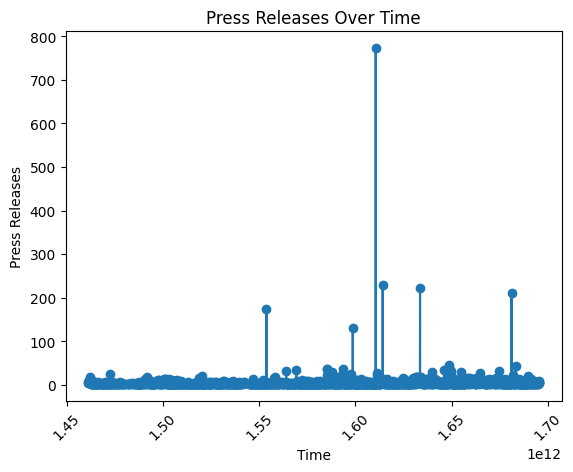

In [58]:
# Calculate and plot press release distribution over time
if "target_timestamp" in data.columns:
    time_dist = data.group_by("target_timestamp").len().sort("target_timestamp")
    plt.plot(time_dist["target_timestamp"], time_dist["len"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Press Releases")
    plt.title("Press Releases Over Time")
    plt.xticks(rotation=45)
    plt.show()

Article Length Distribution:
shape: (9, 2)
┌────────────┬────────────────┐
│ statistic  ┆ article_length │
│ ---        ┆ ---            │
│ str        ┆ f64            │
╞════════════╪════════════════╡
│ count      ┆ 10365.0        │
│ null_count ┆ 0.0            │
│ mean       ┆ 4218.3315      │
│ std        ┆ 9118.901825    │
│ min        ┆ 24.0           │
│ 25%        ┆ 1038.0         │
│ 50%        ┆ 2580.0         │
│ 75%        ┆ 4964.0         │
│ max        ┆ 411363.0       │
└────────────┴────────────────┘


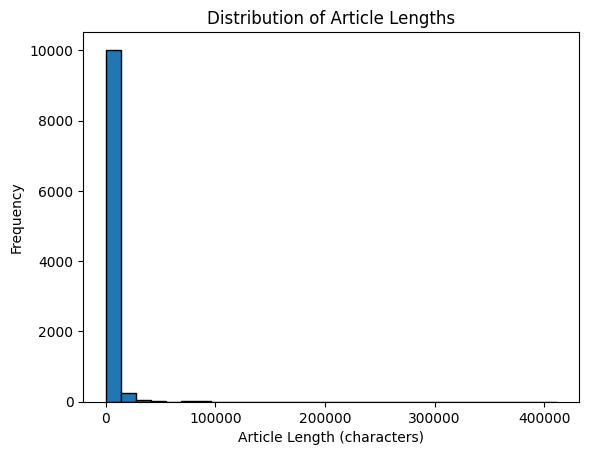

In [63]:
# Calculate and plot article length distribution
if "resolved_text" in data.columns:
    article_length_distribution = data.with_columns(
        pl.col("resolved_text").list.join(" ").alias("resolved_text")
    ).with_columns(
        pl.col("resolved_text").str.len_chars().alias("article_length")
    )
    print("Article Length Distribution:")
    print(article_length_distribution.select("article_length").describe())
    plt.hist(article_length_distribution["article_length"].to_list(), bins=30, edgecolor='black')
    plt.xlabel("Article Length (characters)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Article Lengths")
    plt.show()

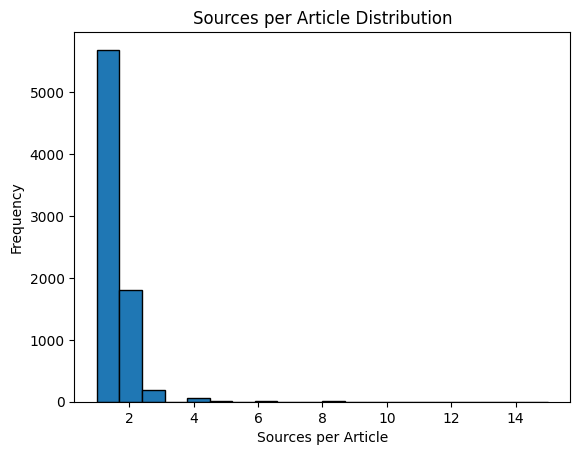

In [64]:
    # Count the number of sources per article and plot the distribution
    src_count = data.group_by("article_url").len().rename({"len": "num_sources"})
    plt.hist(src_count["num_sources"].to_list(), bins=20, edgecolor='black')
    plt.xlabel("Sources per Article")
    plt.ylabel("Frequency")
    plt.title("Sources per Article Distribution")
    plt.show()

In [65]:
    # retrieve and print the top 10 sources and their counts
    top_sources = data.group_by("news_domain").len().sort("len", descending=True).head(10)
    print("Top sources:", top_sources)

Top sources: shape: (10, 2)
┌─────────────────┬──────┐
│ news_domain     ┆ len  │
│ ---             ┆ ---  │
│ str             ┆ u32  │
╞═════════════════╪══════╡
│ businessinsider ┆ 1968 │
│ nj              ┆ 1069 │
│ nytimes         ┆ 438  │
│ ansa            ┆ 437  │
│ cnn             ┆ 285  │
│ propublica      ┆ 276  │
│ fortune         ┆ 258  │
│ usatoday        ┆ 238  │
│ sourcewatch     ┆ 221  │
│ oregonlive      ┆ 214  │
└─────────────────┴──────┘


In [67]:
    # calculate the average article length per source
    avg_length_per_source = article_length_distribution.group_by("news_domain").agg(
        pl.col("article_length").mean().alias("avg_length")
    ).sort("avg_length", descending=True)

    print("Average length of press releases per source:")
    print(avg_length_per_source)

Average length of press releases per source:
shape: (409, 2)
┌─────────────┬──────────────┐
│ news_domain ┆ avg_length   │
│ ---         ┆ ---          │
│ str         ┆ f64          │
╞═════════════╪══════════════╡
│ qgazette    ┆ 107596.0     │
│ alternet    ┆ 78152.111111 │
│ thestranger ┆ 73249.0      │
│ nbcsandiego ┆ 46465.875    │
│ thenation   ┆ 43411.0      │
│ …           ┆ …            │
│ ocbj        ┆ 380.666667   │
│ seattlepi   ┆ 285.0        │
│ finance     ┆ 152.0        │
│ asahi       ┆ 66.333333    │
│ scmp        ┆ 66.0         │
└─────────────┴──────────────┘


Press releases with more than 500 words:
shape: (5_296, 3)
┌─────────────────────────────────┬─────────────────────────────────┬───────────┐
│ article_url                     ┆ title                           ┆ company   │
│ ---                             ┆ ---                             ┆ ---       │
│ str                             ┆ str                             ┆ str       │
╞═════════════════════════════════╪═════════════════════════════════╪═══════════╡
│ www.bbc.co.uk/blogs/researchan… ┆ BBC - Research and Development… ┆ amd       │
│ www.bbc.co.uk/blogs/researchan… ┆ BBC - Research and Development… ┆ keysight  │
│ www.prweb.com/releases/2015/02… ┆ The Socrata Foundation Establi… ┆ tylertech │
│ thehill.com/changing-america/w… ┆ Teens confide in certain adult… ┆ cvshealth │
│ thehill.com/changing-america/w… ┆ Teens confide in certain adult… ┆ cvshealth │
│ …                               ┆ …                               ┆ …         │
│ www.wsj.com/articles/universit… ┆ Onc

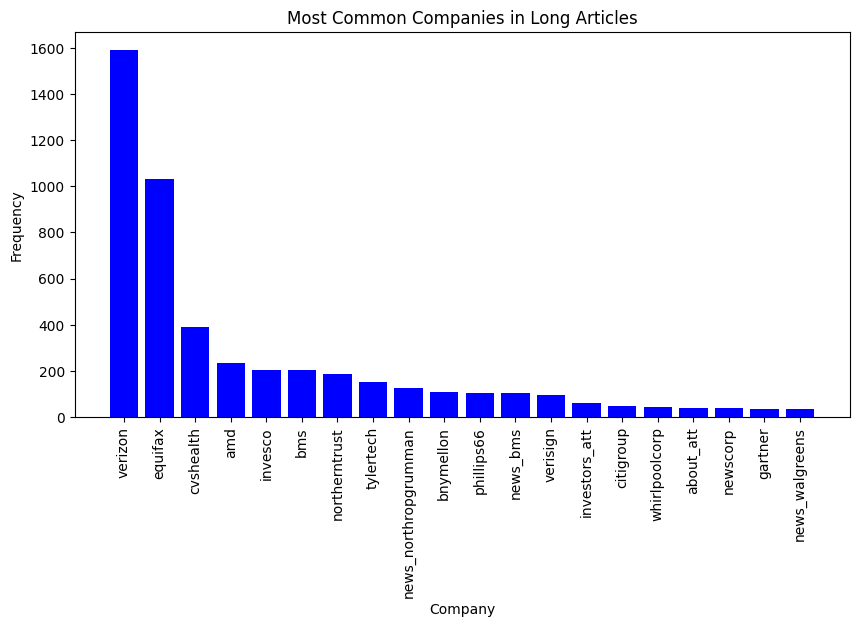

In [75]:
    # Get just the articles with more than 500 words.
    long_articles = article_length_distribution.filter(
        pl.col("article_length") > 2500
    )
    print("Press releases with more than 500 words:")
    print(long_articles.select(["article_url", "title", "company"]))

    # Find the most common companies in long articles and plot
    top_companies = long_articles.group_by("company").len().sort("len", descending=True).head(20)
    print("Most common companies in long articles:")
    print(top_companies)
    plt.figure(figsize=(10, 5))
    plt.bar(top_companies["company"].to_list(), top_companies["len"].to_list(), color='blue')
    plt.xlabel("Company")
    plt.ylabel("Frequency")
    plt.title("Most Common Companies in Long Articles")
    plt.xticks(rotation=90)
    plt.show()